In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
from postgis.psycopg import register
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import box
import project_path
from db_importer.settings import *
import scipy.stats
from scipy.stats import ks_2samp


class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [2]:
start_rect = box(13.4538,52.5143,13.4545,52.5154)
end_rect = box(13.4518,52.516,13.453,52.5163)

def get_SUMO_durations(x):
    
    mask_first = x.apply(lambda coord: start_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    mask_end = x.apply(lambda coord: end_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    vehicle_id = x.iloc[0].vehicle_id
    try:
        start = x[mask_first==True].iloc[0].timestep_time
        end = x[mask_end==True].iloc[0].timestep_time
        return (vehicle_id, end - start)
    except: 
        return None, None
    

In [3]:
files= ['../sim_data/warschauer_default.csv', '../sim_data/warschauer_new_params_all.csv', '../sim_data/warschauer_new_params_slow.csv', '../sim_data/warschauer_new_params_medium.csv', '../sim_data/warschauer_new_params_fast.csv',
'../sim_data/warschauer_i_new_params_all.csv', '../sim_data/warschauer_i_new_params_slow.csv', '../sim_data/warschauer_i_new_params_medium.csv', '../sim_data/warschauer_i_new_params_fast.csv', '../sim_data/warschauer_i_default.csv']

durations_arr = []

for file in files:
    df = pd.read_csv(file, delimiter=';')
    print(len(df))
    df = df[df.vehicle_id.str.startswith('flow', na=False)]
    
    grouped = df.groupby('vehicle_id')
    durations = grouped.apply(lambda x: get_SUMO_durations(x)[1]).dropna()
    durations_arr.append(durations.values)
    


35446
45596
45596
34060
28987
52369
52369
40537
35555
46253


In [4]:
from statsmodels.distributions.empirical_distribution import ECDF

with DatabaseConnection() as cur:
    velo_filter = lambda name: f"{name} > 0.2 AND {name} != 'NaN' AND {name} < 15"
    group_q = lambda perc: f"""SELECT percentile_cont({perc}) WITHIN GROUP (ORDER BY one.avg_v) FROM (SELECT AVG(velo) as avg_v FROM accels WHERE velo > 0.2 AND velo != 'NaN' AND velo < 15 GROUP BY filename) as one"""
    cur.execute(f"""
    SELECT *, CASE WHEN one.avg_v < ({group_q("0.25")}) THEN 0 ELSE CASE WHEN one.avg_v < ({group_q("0.75")}) THEN 1 ELSE 2 END END as group FROM (
        SELECT 
        filename,
        ST_AsGeoJSON(geom) :: json->'coordinates' AS coordinates,
        timestamps,
        timestamps[1],
        velos,
        (SELECT AVG(velo2) FROM unnest(velos) velo2 WHERE {velo_filter("velo2")}) as avg_v
        FROM public.ride 
        WHERE st_intersects(geom,
        st_setsrid( st_makebox2d( st_makepoint(13.4538,52.5143), st_makepoint(13.4545,52.5154)), 4326))
        AND
        st_intersects(geom,
                     st_setsrid( st_makebox2d( st_makepoint(13.4518,52.516), st_makepoint(13.453,52.5163)), 4326))
        AND NOT
        st_intersects(geom, st_setsrid( st_makebox2d( st_makepoint(13.4533,52.5155), st_makepoint(13.4538,52.5158)), 4326))
        and not 
        st_intersects(geom, st_setsrid( st_makebox2d( st_makepoint(13.4535,52.5161), st_makepoint(13.4547,52.5164)), 4326))
    ) as one""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'ts1', 'velo', 'avg_v', 'group'])
    print(len(df))

def get_ride_durations(arr):
    coords = np.array(arr[0])
    timestamps = np.array(arr[1])
    first = None
    last = None
    for i, coord in enumerate(coords):
        point = Point(coord[0],coord[1])
        if (first is None) & start_rect.contains(point):
            first = i
            continue
        if (first is not None) & end_rect.contains(point):
            last = i
            break
    try:
        res = (timestamps[last] - timestamps[first]).total_seconds()
        if res > 500:
            return None
    except:
        res = None
    return res

test = df.apply(lambda x: get_ride_durations(x[['coords', 'timestamps']]), axis=1)
simra_durations = test[~test.isnull()].values
test = df.query('group == 0').apply(lambda x: get_ride_durations(x[['coords', 'timestamps']]), axis=1)
simra_durations_slow = test[~test.isnull()].values
test = df.query('group == 1').apply(lambda x: get_ride_durations(x[['coords', 'timestamps']]), axis=1)
simra_durations_medium = test[~test.isnull()].values
test = df.query('group == 2').apply(lambda x: get_ride_durations(x[['coords', 'timestamps']]), axis=1)
simra_durations_fast = test[~test.isnull()].values

print("SimRa (All) vs Default: " + str(ks_2samp(durations_arr[0], simra_durations)))
print("SimRa (All) vs All: " + str(ks_2samp(durations_arr[1], simra_durations)))
# no data print("SimRa (Slow) vs Slow: " + str(ks_2samp(durations_arr[2], simra_durations_slow)))
print("SimRa (Medium) vs Medium: " + str(ks_2samp(durations_arr[3], simra_durations_medium)))
print("SimRa (Fast) vs Fast: " + str(ks_2samp(durations_arr[4], simra_durations_fast)))

print("SimRa (All) vs Default - indirect: " + str(ks_2samp(durations_arr[9], simra_durations)))
print("SimRa (All) vs All - indirect: " + str(ks_2samp(durations_arr[5], simra_durations)))
# no data print("SimRa (Slow) vs Slow - indirect: " + str(ks_2samp(durations_arr[6], simra_durations_slow)))
print("SimRa (Medium) vs Medium - indirect: " + str(ks_2samp(durations_arr[7], simra_durations_medium)))
print("SimRa (Fast) vs Fast - indirect: " + str(ks_2samp(durations_arr[8], simra_durations_fast)))


39
SimRa (All) vs Default: KstestResult(statistic=0.355982905982906, pvalue=0.0003899591477004976)
SimRa (All) vs All: KstestResult(statistic=0.24102564102564103, pvalue=0.039605266435544205)
SimRa (Medium) vs Medium: KstestResult(statistic=0.7888888888888889, pvalue=1.199427935730388e-06)
SimRa (Fast) vs Fast: KstestResult(statistic=0.2921455938697318, pvalue=0.02166572631731718)
SimRa (All) vs Default - indirect: KstestResult(statistic=0.4337606837606838, pvalue=5.676152597624065e-06)
SimRa (All) vs All - indirect: KstestResult(statistic=0.455982905982906, pvalue=1.422927306261888e-06)
SimRa (Medium) vs Medium - indirect: KstestResult(statistic=0.40555555555555556, pvalue=0.06655246543022875)
SimRa (Fast) vs Fast - indirect: KstestResult(statistic=0.39176245210727967, pvalue=0.000589625099120526)


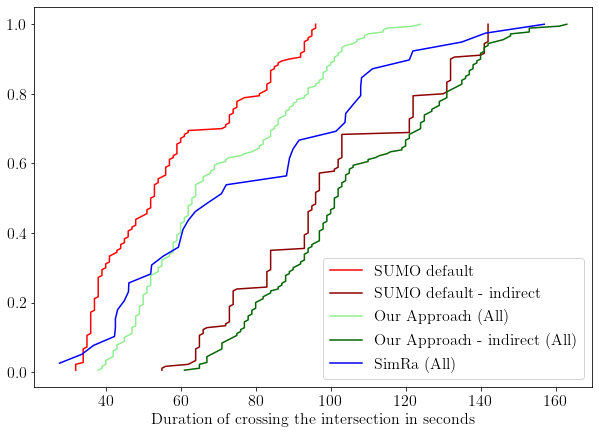

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import rc

colors = ['blue', 'lightgreen', 'darkgreen']

plt.figure(figsize=(10,7))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
#plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='r', label='SUMO default')
ecdf = ECDF(durations_arr[9])
plt.plot(ecdf.x, ecdf.y, c='darkred', label='SUMO default - indirect')
ecdf = ECDF(durations_arr[1])
plt.plot(ecdf.x, ecdf.y, c=colors[1], label='Our Approach (All)')
ecdf = ECDF(durations_arr[5])
plt.plot(ecdf.x, ecdf.y, c=colors[2], label='Our Approach - indirect (All)')
ecdf = ECDF(simra_durations)
plt.plot(ecdf.x, ecdf.y, c=colors[0], label='SimRa (All)')
plt.legend()
plt.savefig('images/im_warschauer_ecdf_all.png', dpi=300, bbox_inches='tight')

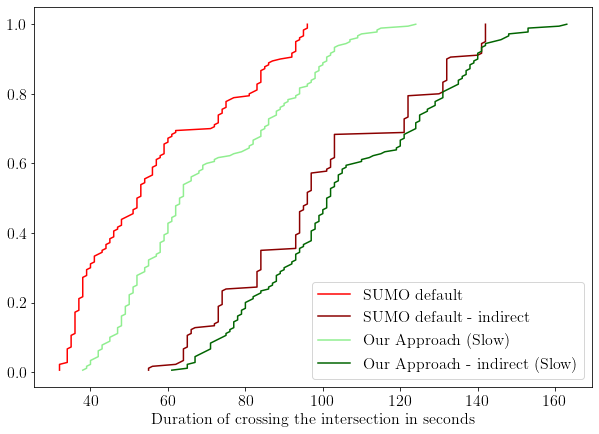

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import rc

colors = ['blue', 'lightgreen', 'darkgreen']

plt.figure(figsize=(10,7))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
#plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='r', label='SUMO default')
ecdf = ECDF(durations_arr[9])
plt.plot(ecdf.x, ecdf.y, c='darkred', label='SUMO default - indirect')
ecdf = ECDF(durations_arr[2])
plt.plot(ecdf.x, ecdf.y, c=colors[1], label='Our Approach (Slow)')
ecdf = ECDF(durations_arr[6])
plt.plot(ecdf.x, ecdf.y, c=colors[2], label='Our Approach - indirect (Slow)')
#ecdf = ECDF(simra_durations_slow)
#plt.plot(ecdf.x, ecdf.y, c=colors[0], label='SimRa (Slow)')
plt.legend()
plt.savefig('images/im_warschauer_ecdf_slow.png', dpi=300, bbox_inches='tight')

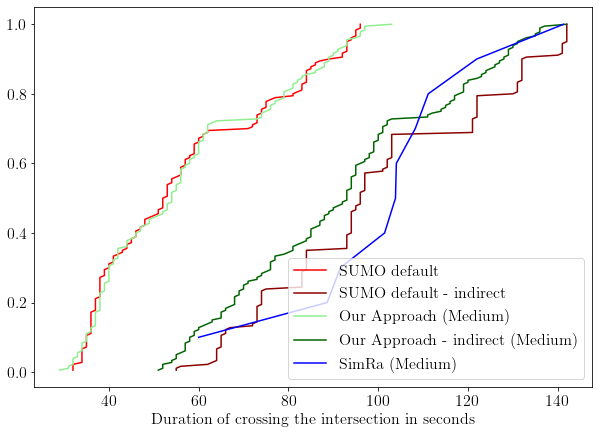

In [7]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import rc

colors = ['blue', 'lightgreen', 'darkgreen']

plt.figure(figsize=(10,7))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
#plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='r', label='SUMO default')
ecdf = ECDF(durations_arr[9])
plt.plot(ecdf.x, ecdf.y, c='darkred', label='SUMO default - indirect')
ecdf = ECDF(durations_arr[3])
plt.plot(ecdf.x, ecdf.y, c=colors[1], label='Our Approach (Medium)')
ecdf = ECDF(durations_arr[7])
plt.plot(ecdf.x, ecdf.y, c=colors[2], label='Our Approach - indirect (Medium)')
ecdf = ECDF(simra_durations_medium)
plt.plot(ecdf.x, ecdf.y, c=colors[0], label='SimRa (Medium)')
plt.legend()
plt.savefig('images/im_warschauer_ecdf_medium.png', dpi=300, bbox_inches='tight')

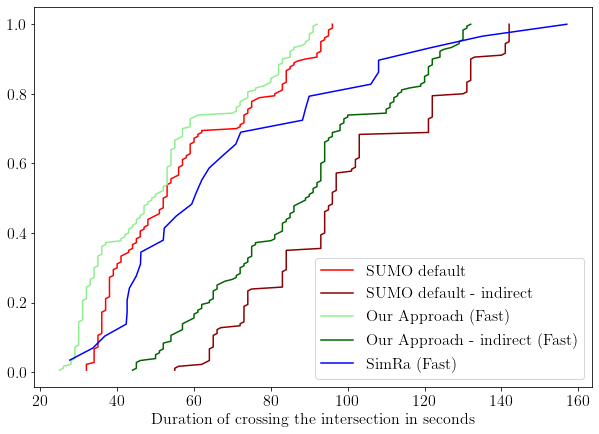

In [8]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import rc

colors = ['blue', 'lightgreen', 'darkgreen']

plt.figure(figsize=(10,7))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
#plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='r', label='SUMO default')
ecdf = ECDF(durations_arr[9])
plt.plot(ecdf.x, ecdf.y, c='darkred', label='SUMO default - indirect')
ecdf = ECDF(durations_arr[4])
plt.plot(ecdf.x, ecdf.y, c=colors[1], label='Our Approach (Fast)')
ecdf = ECDF(durations_arr[8])
plt.plot(ecdf.x, ecdf.y, c=colors[2], label='Our Approach - indirect (Fast)')
ecdf = ECDF(simra_durations_fast)
plt.plot(ecdf.x, ecdf.y, c=colors[0], label='SimRa (Fast)')
plt.legend()
plt.savefig('images/im_warschauer_ecdf_fast.png', dpi=300, bbox_inches='tight')